In [25]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os

import utilities

In [2]:
def plot_series(series, time=None, line='-', start=0, end=None, label=None,
                vlinex=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if time is None:
        time = range(len(series))
    ax.plot(time[start:end], series[start:end], line, label=label)
    if vlinex is not None:
        ax.axvline(vlinex, c='r')
    utilities.set_ax(ax, xlabel='Time', legend=label is not None, grid=True)
    
def trend(time, slope=0):
    return slope * time

pattern = lambda t: np.where(t < 0.4, np.cos(2*np.pi*t), np.exp(-3*t))

def pattern2series(pattern, time, period, amp=1, phase=0):
    return amp*pattern((time/period + phase) % 1)

def noise(time, noise_std=1, rng=np.random.RandomState(0)):
    return rng.randn(len(time)) * noise_std

def autocor(time, lags, coefs, noise_std=1, ini=0, rng=np.random.RandomState(0)):
    maxlag = max(lags)
    s = rng.randn(maxlag + len(time)) * noise_std
    s[:maxlag] += ini
    for i in range(maxlag, maxlag + len(time)):
        s[i] += sum(c*s[i-lag]for lag, c in zip(lags, coefs))
    return s[maxlag:]

def autocor2(time, coef, noise_std=1, rng=np.random.RandomState(0)):
    s = rng.randn(len(time)) * noise_std
    for i in range(1, len(time)):
        s[i] += coef * s[i-1]
    return s

def impulse(time, num, amp=1, rng=np.random.RandomState(0)):
    ind = rng.choice(np.arange(len(time)), num, replace=False)
    s = np.zeros_like(time, dtype=np.float64)
    s[ind] += rng.rand(num) * amp
    return s

def autocor3(series, lagcoef):
    s = series.copy()
    for i, _ in enumerate(s):
        s[i] += sum(coef * s[i-lag] for lag, coef in lagcoef.items() if i >= lag)
    return s

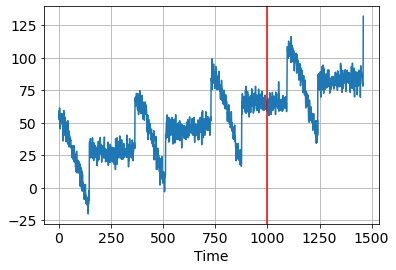

In [3]:
time = np.arange(4*365 + 1.)

baseline = 10
amp = 40
slope = 0.05
noise_std = 5

series = (baseline + trend(time, slope=slope)
          + pattern2series(pattern, time, period=365, amp=amp)
          + noise(time, noise_std=noise_std))

train_size = 1000

train_s, val_s = series[:train_size], series[train_size:]
train_t, val_t = time[:train_size], time[train_size:]

plot_series(series, time, vlinex=time[train_size])

In [4]:
def series2data(series, window, batch, buffer=None):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(size=window+1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window + 1))
    data = data.map(lambda ts: (ts[:-1], ts[-1]))
    data = data.shuffle(buffer_size=len(series) if buffer is None else buffer)
    data = data.batch(batch).prefetch(1)
    return data

In [30]:
window = 20
batch = 32
chpt=os.path.join('tmp', 'val-mae-chpt')

train_data = series2data(train_s, window=window, batch=batch)
val_data = series2data(val_s, window=window, batch=batch)

for d in train_data.take(1):
    print(type(d), d[0].shape, d[1].shape)

<class 'tuple'> (32, 20) (32,)


In [29]:
def fit_nn(model, epochs=20, lr=8e-6, mom=0.9, patience=30, vb=0,
           chpt=os.path.join('tmp', 'val-mae-chpt')):
    callbacks = []
    callbacks.append(keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True
    ))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=chpt,
        monitor='val_mae',
        save_weights_only=True,
        save_best_only=True
    ))
    if lr <= 0:
        ep2lr = lambda ep: 1e-8 * 10**(ep/20)
        callbacks.append(keras.callbacks.LearningRateScheduler(ep2lr))
    
    model.compile(
        loss=keras.losses.Huber(),
        optimizer=keras.optimizers.SGD(learning_rate=lr if lr > 0 else ep2lr(0),
                                       momentum=mom),
        metrics=['mae'],
    )
    
    history = model.fit(
        train_data, epochs=epochs, validation_data=val_data,
        callbacks=callbacks, verbose=vb
    )
    
    if lr > 0:
        utilities.plot_train_val_metrics(history, ['loss', 'mae'], start=5)
    else:
        fig, axs = plt.subplots(1, 2, figsize=[14, 4])
        lrs = ep2lr(np.array(history.epoch))
        for ax in axs:
            ax.semilogx(lrs, history.history['loss'], label='train')
            ax.semilogx(lrs, history.history['val_loss'], label='val')
            utilities.set_ax(ax, 'Learning rate', title='loss', legend=True, grid=True)
        min_loss = min(history.history['loss'])
        axs[1].set_ylim([min_loss, 3*min_loss])
        axs[1].set_xlim([lrs[len(lrs)//2], lrs[-1]])
    
    return model

In [7]:
def plot_pred(model, name='model', combined=False):
    full_data = series2data(series, window=window, batch=128, buffer=1)
    data_x = full_data.map(lambda x, y: x)
    pred = model.predict(data_x).squeeze()
    
    if combined:
        fig, ax = plt.subplots()
        ax.axvline(time[train_size], c='r')
        plot_series(np.c_[series[window:], pred], time[window:], ax=ax,
                    label=['truth', name])

    t_trn, t_val = time[window:train_size], time[train_size:]
    s_trn, s_val = series[window:train_size], series[train_size:]
    pred_trn, pred_val = pred[:train_size-window], pred[train_size-window:]

    rmse_trn = np.sqrt(keras.metrics.mean_squared_error(s_trn, pred_trn))
    mae_trn = keras.metrics.mean_absolute_error(s_trn, pred_trn)

    rmse_val = np.sqrt(keras.metrics.mean_squared_error(s_val, pred_val))
    mae_val = keras.metrics.mean_absolute_error(s_val, pred_val)

    fig, axs = plt.subplots(1, 2, figsize=[14, 4])
    plot_series(np.c_[s_trn, pred_trn], t_trn, ax=axs[0],
                label=('truth', f'{name} rmse={rmse_trn:.3g}, mae={mae_trn:.3g}'))
    plot_series(np.c_[s_val, pred_val], t_val, ax=axs[1],
                label=('truth', f'{name} rmse={rmse_val:.3g}, mae={mae_val:.3g}'))

In [8]:
def build_nn(dense_d=0):
    if dense_d == 0:
        layers = [keras.layers.Dense(1, input_shape=[window])]
    elif isinstance(dense_d, int):
        layers = [
            keras.layers.Dense(dense_d, input_shape=[window], activation='relu'),
            keras.layers.Dense(1),
        ]
    else:
        layers = (
            [keras.layers.Dense(dense_d[0], input_shape=[window], activation='relu')]
            + [keras.layers.Dense(d, activation='relu') for d in dense_d[1:]]
            + [keras.layers.Dense(1)]
        )   
        
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 26.7 s
Wall time: 17.5 s


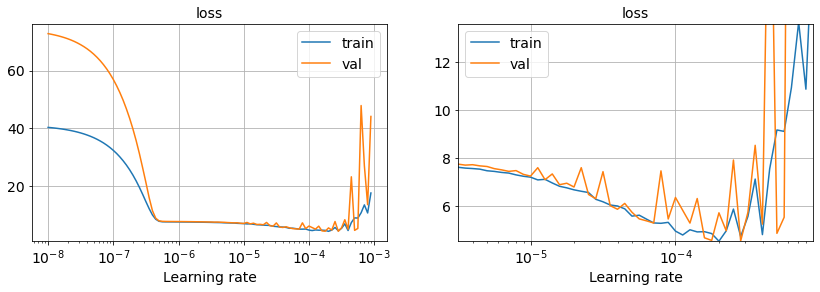

In [9]:
%%time
model = fit_nn(build_nn(), epochs=100, lr=-1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 6ms/step
CPU times: total: 25.6 s
Wall time: 17 s


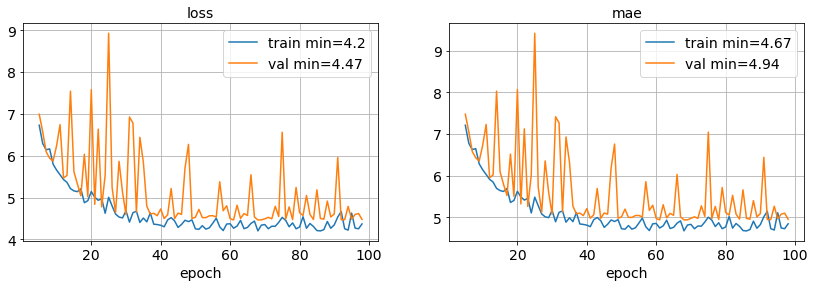

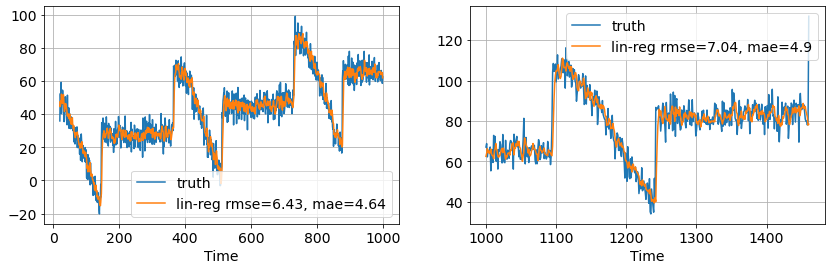

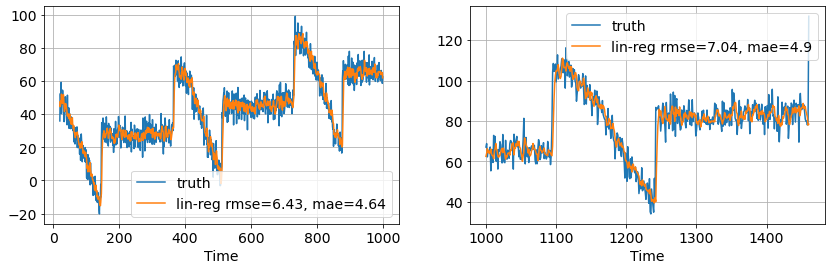

In [31]:
%%time
model = fit_nn(build_nn(), epochs=300, lr=6e-5)
plot_pred(model, 'lin-reg')
model.load_weights(chpt)
plot_pred(model, 'lin-reg')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 28.4 s
Wall time: 18.2 s


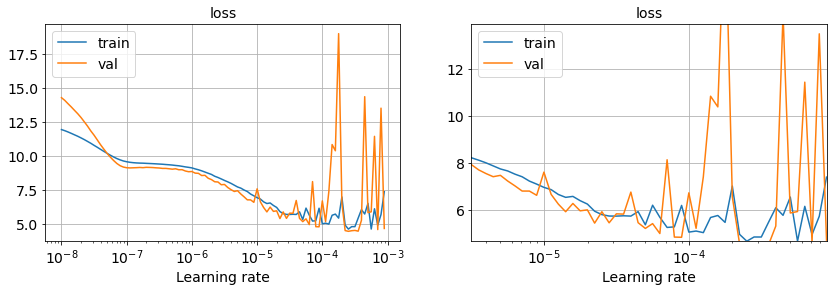

In [11]:
%%time
model = fit_nn(build_nn(dense_d=20), epochs=100, lr=-1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 7ms/step
CPU times: total: 2min 18s
Wall time: 1min 30s


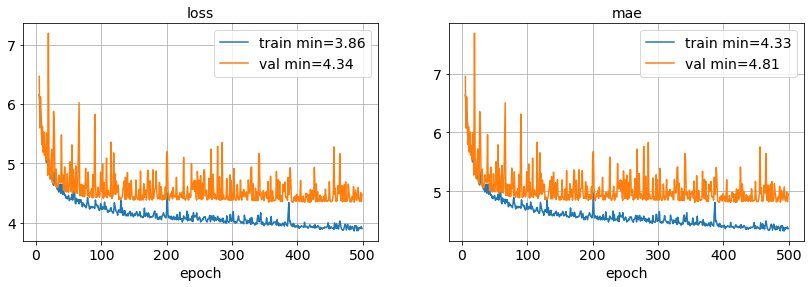

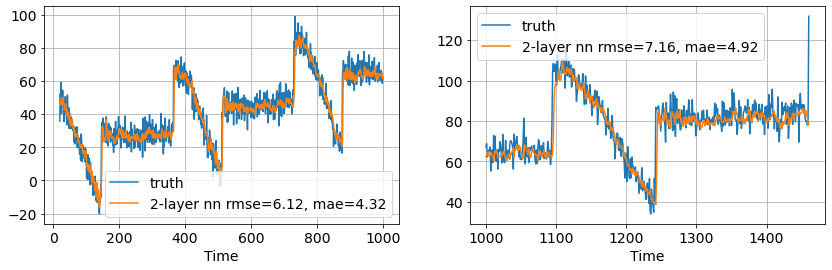

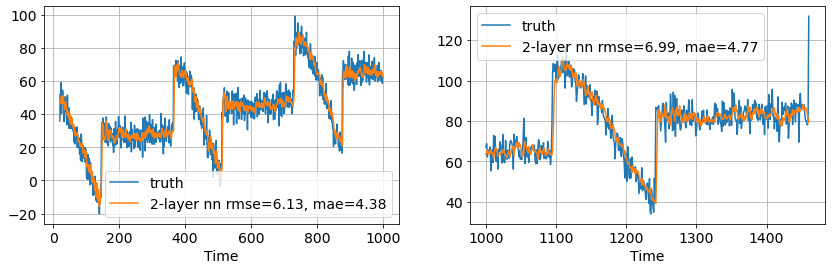

In [34]:
%%time
model = fit_nn(build_nn(dense_d=20), epochs=500, lr=3e-5, patience=100)
plot_pred(model, '2-layer nn')
model.load_weights(chpt)
plot_pred(model, '2-layer nn')

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 31.4 s
Wall time: 22.2 s


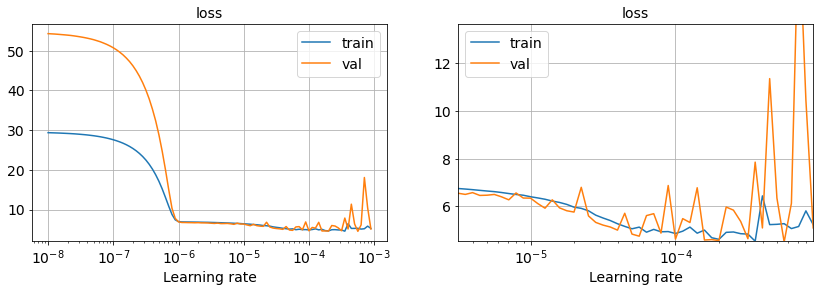

In [41]:
%%time
model = fit_nn(build_nn(dense_d=[10, 10]), epochs=100, lr=-1)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 10)                210       
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 dense_30 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 6ms/step
CPU times: total: 2min 26s
Wall time: 1min 39s


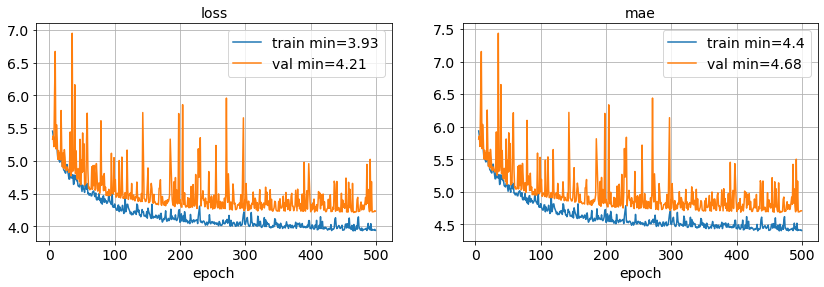

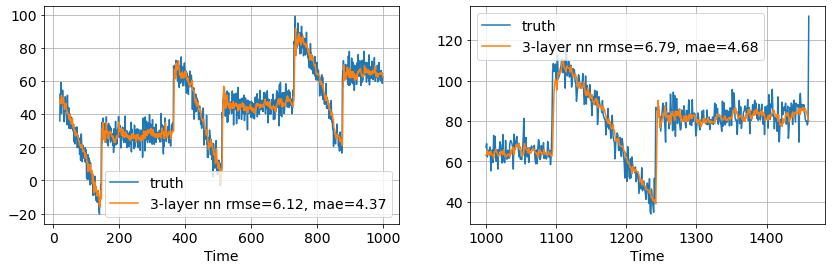

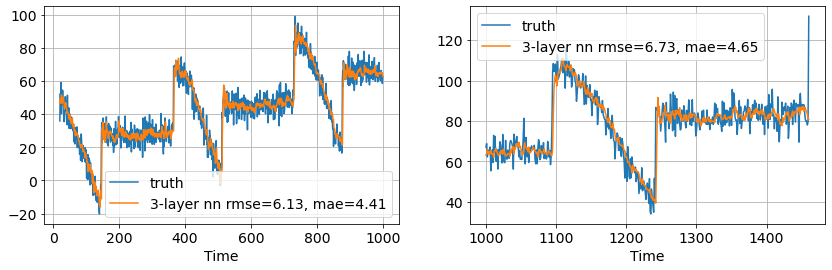

In [42]:
%%time
model = fit_nn(build_nn(dense_d=[10, 10]), epochs=500, lr=4e-5, patience=100)
plot_pred(model, '3-layer nn')
model.load_weights(chpt)
plot_pred(model, '3-layer nn')

In [13]:
def build_rnn(rnn_d=[40]):
    layers = [keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                  input_shape=[window])]
    layers += [keras.layers.SimpleRNN(d, return_sequences=True) for d in rnn_d[:-1]]
    layers += [
        keras.layers.SimpleRNN(rnn_d[-1]),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 100.)
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
31/31 [==============================] -

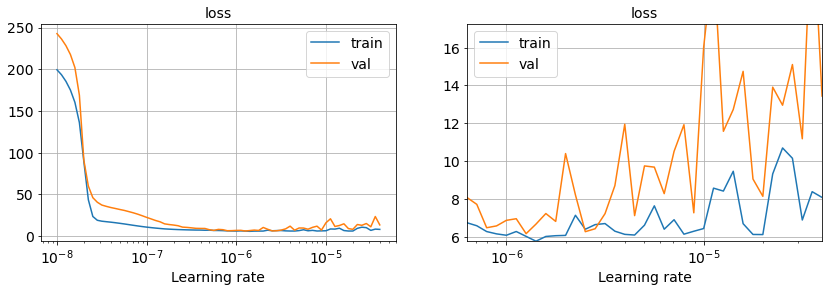

In [14]:
%%time
model = fit_nn(build_rnn(rnn_d=[40, 40]), epochs=120, lr=-1, vb=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_17 (Dense)            (None, 1)                 41        
                                                                 
 lambda_9 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] 

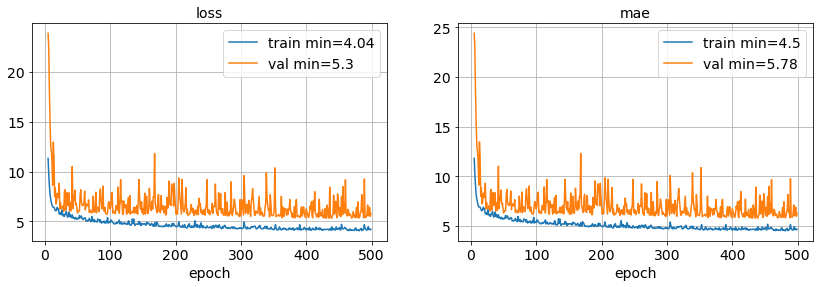

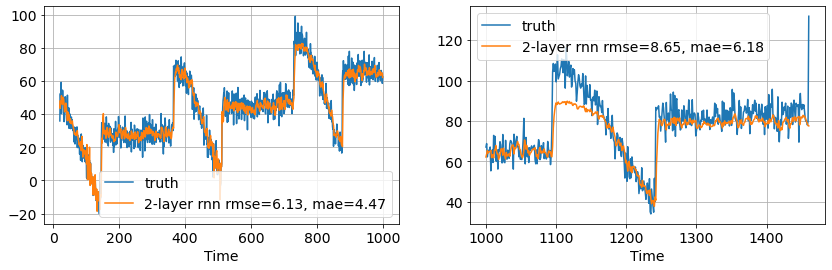

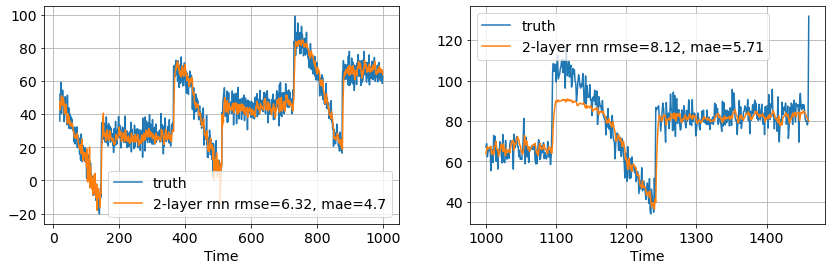

In [33]:
%%time
model = fit_nn(build_rnn(rnn_d=[40, 40]), epochs=500, lr=1e-6, vb=1, patience=100)
plot_pred(model, '2-layer rnn')
model.load_weights(chpt)
plot_pred(model, '2-layer rnn')

In [36]:
def build_lstm(lstm_d=[32], bi=False):
    ly = keras.layers
    wrap = (lambda x: ly.Bidirectional(x)) if bi else (lambda x: x)
    
    layers = [ly.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[window])]
    layers += [wrap(ly.LSTM(d, return_sequences=True)) for d in lstm_d[:-1]]
    layers += [
        wrap(ly.LSTM(lstm_d[-1])),
        ly.Dense(1),
        ly.Lambda(lambda x: x * 100.)
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_12 (Lambda)          (None, 20, 1)             0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 32)            4352      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
 lambda_13 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
31/31 [==============================

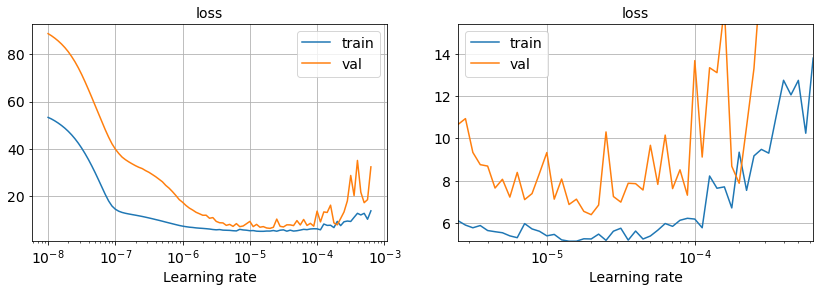

In [37]:
%%time
model = fit_nn(build_lstm(lstm_d=[32, 32]), epochs=120, lr=-1, vb=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_14 (Lambda)          (None, 20, 1)             0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
 lambda_15 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================

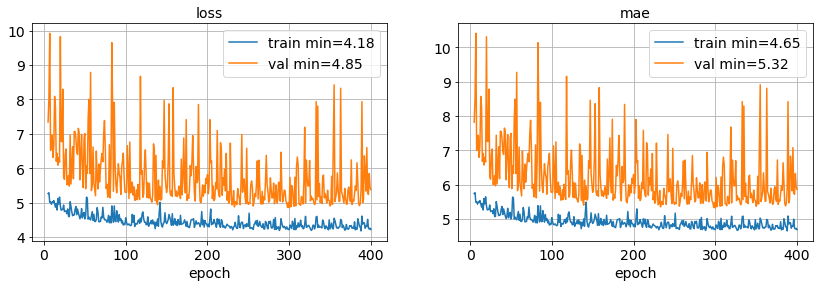

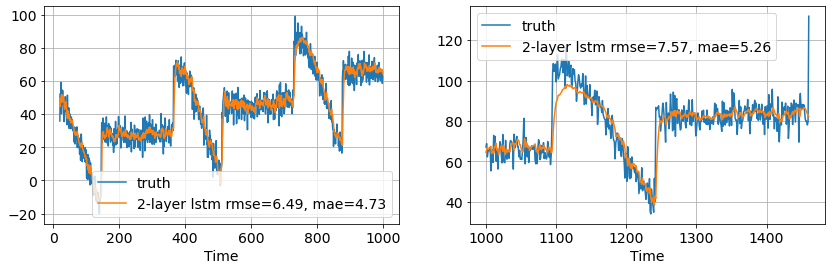

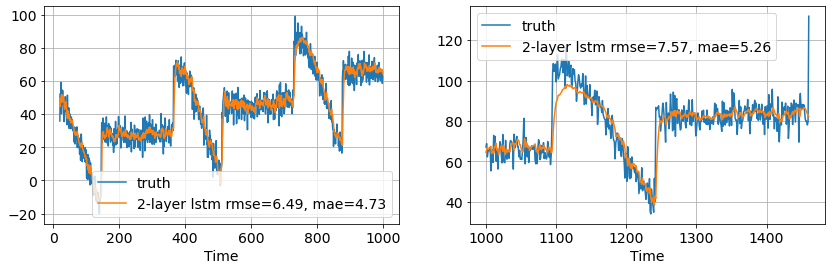

In [38]:
%%time
model = fit_nn(build_lstm(lstm_d=[32, 32]), epochs=500, lr=8e-6, vb=1, patience=100)
plot_pred(model, '2-layer lstm')
model.load_weights(chpt)
plot_pred(model, '2-layer lstm')

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_16 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
 lambda_17 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-tra

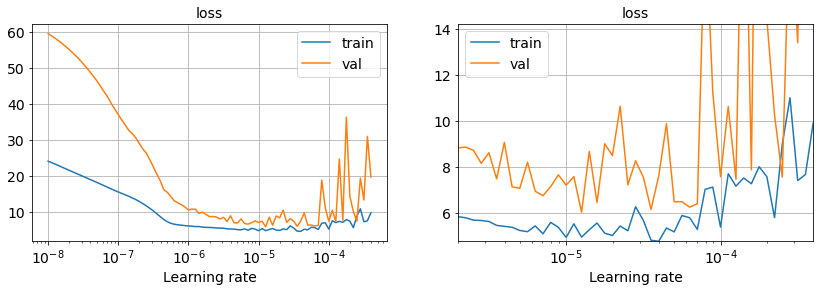

In [39]:
%%time
model = fit_nn(build_lstm(lstm_d=[32, 32], bi=True), epochs=100, lr=-1, vb=1)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
 lambda_19 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-tra

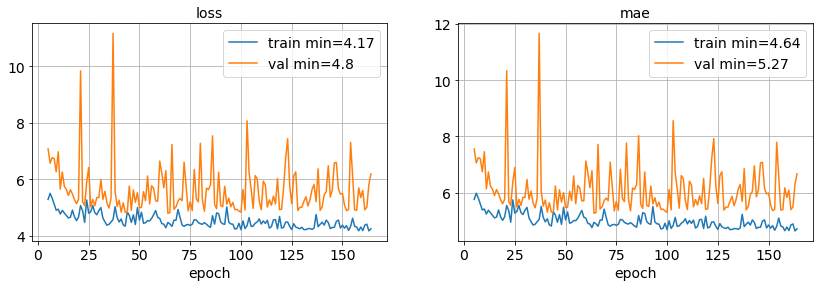

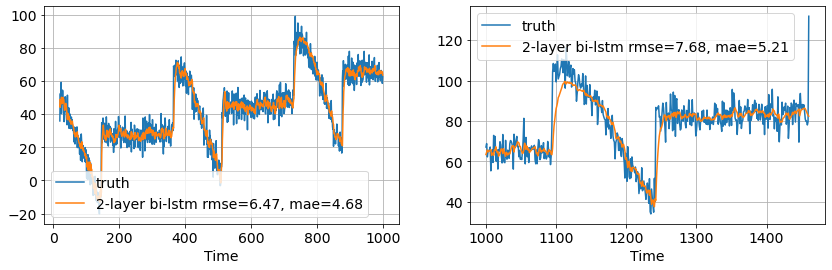

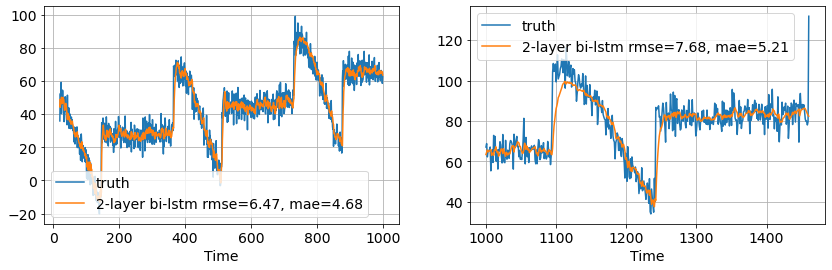

In [40]:
%%time
model = fit_nn(build_lstm(lstm_d=[32, 32], bi=True), epochs=500, lr=1e-5, vb=1, patience=100)
plot_pred(model, '2-layer bi-lstm')
model.load_weights(chpt)
plot_pred(model, '2-layer bi-lstm')

In [44]:
keras.backend.clear_session()

In [56]:
def build_cnn(convfil=32, convwid=5):
    ly = keras.layers
    layers = [
        ly.Conv1D(convfil, convwid, activation='relu', input_shape=[window, 1]),
        ly.Flatten(),
        ly.Dense(1),
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 16, 32)            192       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 1s 12ms/step - loss: 42.1842 - mae: 42.6832 - val_loss: 78.2995 - val_mae: 78.7995 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 42.1400 - mae: 42.6390 - val_loss: 78.2065 - val_mae: 78.7065 - lr: 1.1220e-08
Epoch 3/100
31/

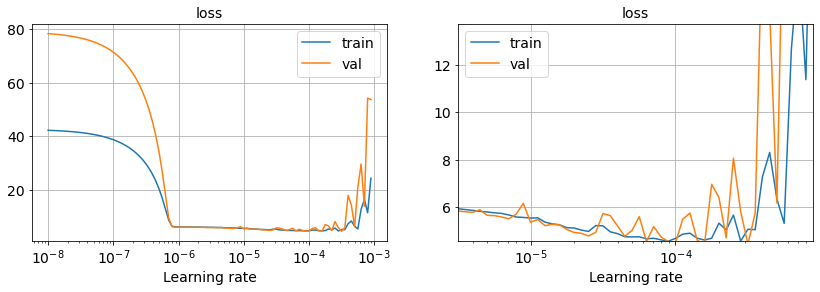

In [57]:
%%time
model = build_cnn()
ini_wts = model.get_weights()
fit_nn(model, epochs=100, lr=-1, vb=1)

Epoch 1/500
31/31 - 1s - loss: 15.9255 - mae: 16.4218 - val_loss: 5.6837 - val_mae: 6.1588 - 556ms/epoch - 18ms/step
Epoch 2/500
31/31 - 0s - loss: 6.0022 - mae: 6.4786 - val_loss: 6.2387 - val_mae: 6.7226 - 202ms/epoch - 7ms/step
Epoch 3/500
31/31 - 0s - loss: 5.4983 - mae: 5.9767 - val_loss: 4.9203 - val_mae: 5.3917 - 217ms/epoch - 7ms/step
Epoch 4/500
31/31 - 0s - loss: 5.0030 - mae: 5.4800 - val_loss: 7.0856 - val_mae: 7.5705 - 187ms/epoch - 6ms/step
Epoch 5/500
31/31 - 0s - loss: 5.2449 - mae: 5.7213 - val_loss: 4.6620 - val_mae: 5.1315 - 211ms/epoch - 7ms/step
Epoch 6/500
31/31 - 0s - loss: 5.0268 - mae: 5.5040 - val_loss: 5.2961 - val_mae: 5.7778 - 181ms/epoch - 6ms/step
Epoch 7/500
31/31 - 0s - loss: 5.2320 - mae: 5.7119 - val_loss: 10.1749 - val_mae: 10.6714 - 177ms/epoch - 6ms/step
Epoch 8/500
31/31 - 0s - loss: 5.1759 - mae: 5.6545 - val_loss: 8.3780 - val_mae: 8.8639 - 180ms/epoch - 6ms/step
Epoch 9/500
31/31 - 0s - loss: 4.8969 - mae: 5.3751 - val_loss: 4.7294 - val_mae: 5

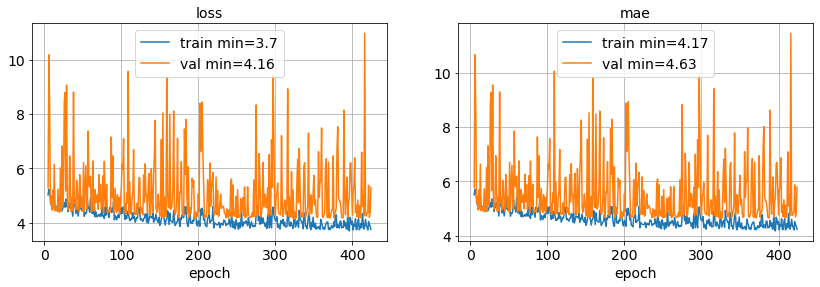

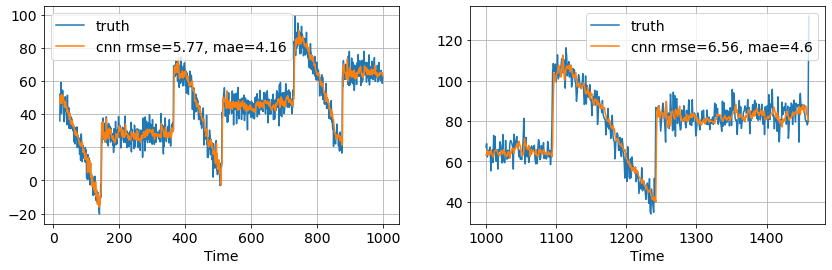

In [58]:
%%time
model.set_weights(ini_wts)
fit_nn(model, epochs=500, lr=1e-4, vb=2, patience=100)
model.load_weights(chpt)
plot_pred(model, 'cnn')

In [48]:
def build_conv_lstm(convfil=32, convwid=5, lstm_d=[32, 32]):
    ly = keras.layers
    layers = [ly.Conv1D(convfil, convwid, activation='relu', input_shape=[window, 1])]
    layers += [ly.Bidirectional(ly.LSTM(d, return_sequences=True)) for d in lstm_d[:-1]]
    layers += [
        ly.Bidirectional(ly.LSTM(lstm_d[-1])),
        ly.Dense(1),
        ly.Lambda(lambda x: x * 100.),
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 16, 32)            192       
                                                                 
 bidirectional_2 (Bidirectio  (None, 16, 64)           16640     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-traina

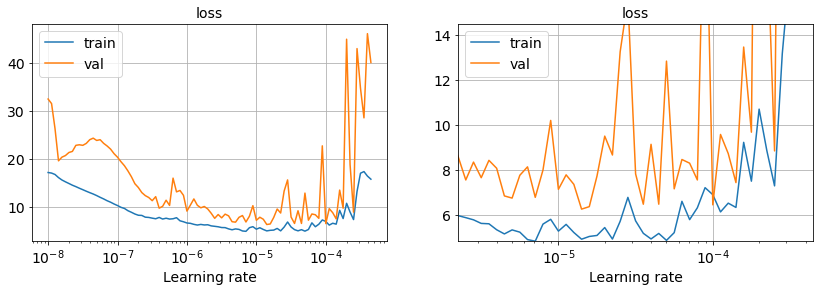

In [49]:
%%time
model = fit_nn(build_conv_lstm(), epochs=100, lr=-1, vb=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 16, 32)            192       
                                                                 
 bidirectional_6 (Bidirectio  (None, 16, 64)           16640     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-trai

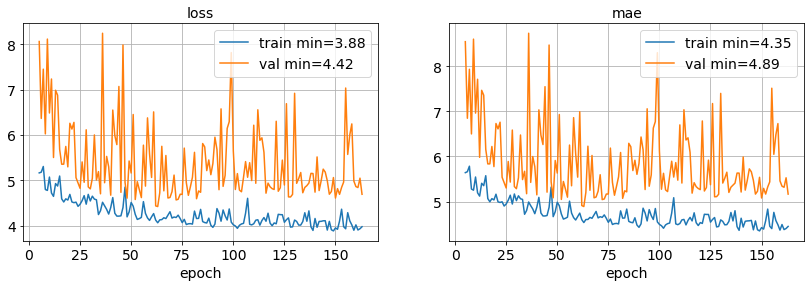

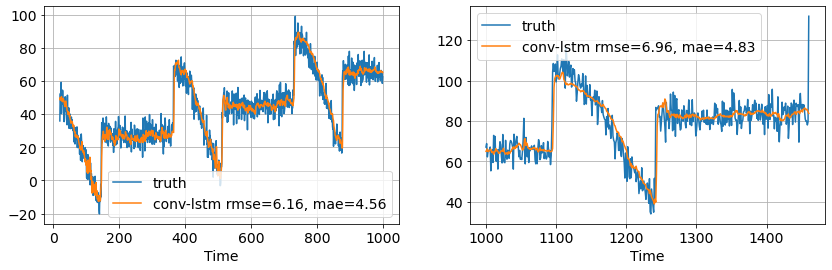

In [59]:
%%time
model = fit_nn(build_conv_lstm(), epochs=1000, lr=1e-5, vb=2, patience=100)
model.load_weights(chpt)
plot_pred(model, 'conv-lstm')